In [1]:
%matplotlib ipympl
import numpy as np
import sys
import time
from joblib import Parallel, delayed

# setting path for mask_utils package
sys.path.append('..')

from mask_utils.code_utils import next_prime, ura_mura
from mask_utils.imaging_utils import decode, decode_var, eff_area_vs_off_axis, solid_angle
from mask_utils.image_utils import upscale, fshift, ferosion, apply_vignetting
from mask_utils.fits_utils import read_mask_bulk
from scipy.signal import convolve
from scipy.ndimage import gaussian_filter
from scipy.ndimage import convolve1d # Optimized for 1D kernels

import matplotlib.pyplot as plt
from matplotlib import cm

In [2]:
def wfm_psfy(y):
    center, alpha, beta, sigma = 0, 0.5459735904725987, 0.7363355668833482, 0.17749677955602094 
    psf = 1 / np.cosh(np.abs(( y - center) / alpha) ** beta) 
    psf = gaussian_filter(psf, sigma, mode='constant', cval=0)
    return psf/np.sum(psf)

def model_source_optimized(xsh, ysh, fluence, mask, bulk, psf_1d, FOCAL, ELXDIM, ELYDIM, MTHICK, datatype="reconstructed"):
    """
    Optimized version of model_source using 1D convolution for speed.
    """
    _shifted = fshift(mask, xsh, ysh)
    _vignetted = apply_vignetting(_shifted, xsh, ysh, FOCAL, ELXDIM, ELYDIM, MTHICK)

    if datatype == "reconstructed":
        # OPTIMIZATION: Use convolve1d instead of generic 2D convolve
        # The PSF is (1, N), so we convolve along axis 1 (columns)
        _detimage = convolve1d(_vignetted, psf_1d, axis=1, mode='constant', cval=0) * bulk
        _detimage_norm = _detimage/np.sum(_detimage) * fluence 
    else:
        _detimage = _vignetted * bulk
        _detimage_norm = _detimage/np.sum(_detimage) * fluence 
    
    return _detimage_norm

In [3]:
# --- 2. LOAD & PREPROCESS DATA ---

mask_file = "F:/CodedMasks/mask_050_1040x17/mask_050_1040x17_20260129_ELXDIM_250um.fits"

In [4]:
# Read Data
mask, hdmask = read_mask_bulk(mask_file, 'MASK', header_out=True, verbose=False)
rmatrix = read_mask_bulk(mask_file, 'RMATRIX', header_out=False, verbose=False)
bulk = read_mask_bulk(mask_file, 'SENS', header_out=False, verbose=False)
bulk[bulk < 1] = 0

# Parameters
ELXDIM = hdmask['ELXDIM']
ELYDIM = hdmask['ELYDIM']
MTHICK = hdmask['MTHICK']
ELXN   = hdmask['ELXN'] 
ELYN   = hdmask['ELYN']
OPENFR = hdmask['OPENFR']
FOCAL  = 202.9 + 0.150

In [5]:
# Upscaling
up_f_x, up_f_y = 2, 1
mask = upscale(mask, up_f_y, up_f_x)
rmatrix = upscale(rmatrix, up_f_y, up_f_x)
bulk = upscale(bulk, up_f_y, up_f_x)
ELXDIM /= up_f_x
ELYDIM /= up_f_y
ELXN   *= up_f_x
ELYN   *= up_f_y

# PSF Generation
yspan = int(15.5/ELYDIM)
ypsf = np.arange(-yspan, yspan+1) * ELYDIM
# Flatten to 1D array for convolve1d
psf_1d = wfm_psfy(ypsf) 

In [6]:
# --- 3. PRE-COMPUTE CONSTANTS (Background) ---

Crab_on_axis_cm2 = 2.5
CXB_cm2 = 6.7
exposure = 1000.0

qe_factor = 0.974 * 0.999 * 0.99527 * 0.99614 * 0.98945
eff_area_onaxis = 0.01 * eff_area_vs_off_axis(mask.T.astype('int32'), bulk.T, ELXDIM, ELYDIM, FOCAL, MTHICK, 0, 0, degrees=True) * qe_factor

bkg_fluence = eff_area_onaxis * CXB_cm2 * exposure
print("Total bkg counts", bkg_fluence)

bkg_shape = solid_angle(bulk, ELXDIM, ELYDIM, FOCAL, nobulk=False)
detimage_bkg = bkg_shape/np.sum(bkg_shape) * bkg_fluence

Total bkg counts 468448.68345113


In [7]:
# Define the worker function for a single grid point
def process_grid_point(i, j, ThetaX, ThetaY):

    
    # Calculate Effective Area
    eff_area = 0.01 * eff_area_vs_off_axis(mask.T.astype('int32'), bulk.T, ELXDIM, ELYDIM, FOCAL, MTHICK, ThetaX, ThetaY, degrees=True) * qe_factor
    src_fluence = eff_area * Crab_on_axis_cm2 * exposure 

    # Shifts
    ShiftX = -np.tan(np.deg2rad(ThetaX))*FOCAL/ELXDIM
    ShiftY = -np.tan(np.deg2rad(ThetaY))*FOCAL/ELYDIM

    # Generate Model
    # Note: We pass psf_1d and use optimized convolution
    detimage_src = model_source_optimized(ShiftX, ShiftY, src_fluence, mask, bulk, psf_1d, FOCAL, ELXDIM, ELYDIM, MTHICK, datatype="reconstructed")
    
    # Combine Source + Background
    detimage = detimage_src + detimage_bkg

    # Decode
    sky = decode(detimage, rmatrix, bulk)
    var = decode_var(detimage, rmatrix, bulk, FOCAL, ELXDIM, ELYDIM)

    # Extract SNR at peak
    cx, cy = (sky.shape[0] - 1 ) // 2, (sky.shape[1] - 1 ) // 2
    p_x = int(np.round(cx - ShiftX))
    p_y = int(np.round(cy - ShiftY))

    #Using -2:+2 pixel as a search area
    snr = np.max(sky[p_x-2:p_x+2, p_y-2:p_y+2]) / np.sqrt(np.max(var[p_x-2:p_x+2, p_y-2:p_y+2]))
    
    return (i, j, snr)

In [8]:
step = 1 #map step in degrees
ThetaX_arr = np.arange(-45, 0+step, step)
ThetaY_arr = np.arange(-45, 0+step, step)

In [9]:
# --- 4. PARALLELIZED PROCESSING LOOP ---

print(f"Starting parallel simulation on {len(ThetaX_arr)}x{len(ThetaY_arr)} grid...")
start_time = time.time()

# Run Parallel Loop
# n_jobs=-1 uses all available CPUs
results = Parallel(n_jobs=-1)(
    delayed(process_grid_point)(i, j, ThetaX_arr[i], ThetaY_arr[j])
    for i in range(len(ThetaX_arr))
    for j in range(len(ThetaY_arr))
)

# Reassemble results into the matrix
sens_map_quadrant = np.zeros((len(ThetaX_arr), len(ThetaY_arr)))
for res in results:
    i, j, snr = res
    sens_map_quadrant[i, j] = snr

end_time = time.time()
print(f"Simulation completed in {end_time - start_time:.2f} seconds.")



Starting parallel simulation on 46x46 grid...
Simulation completed in 829.05 seconds.


In [10]:
sens_map_half = np.vstack((sens_map_quadrant, sens_map_quadrant[::-1, :][1:, :]))
sens_map_full = np.hstack((sens_map_half, sens_map_half[:, ::-1][:, 1:]))

In [68]:
from scipy.ndimage import uniform_filter

# Define the window size (5x5 pixels)
size = (3,1)

# Apply the minimum filter
# This replaces every pixel with the lowest value found in its 5x5 neighborhood
sens_map_full_filt = uniform_filter(sens_map_full, size=size, mode='nearest')

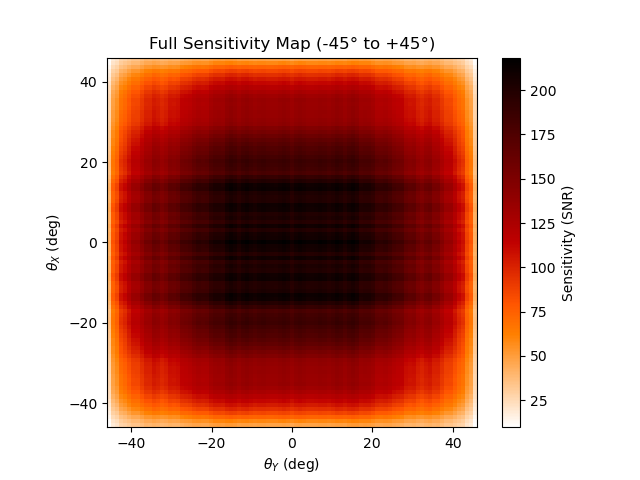

In [69]:
plt.figure()
plt.imshow(sens_map_full_filt,cmap=cm.gist_heat_r, origin='lower', interpolation='none', extent=[-46,46,-46,46])
plt.colorbar(label='Sensitivity (SNR)')
plt.xlabel(r'$\theta_Y$ (deg)')
plt.ylabel(r'$\theta_X$ (deg)')
plt.title('Full Sensitivity Map (-45° to +45°)')
plt.show()

In [70]:
sens_map_mcrab_1s = np.sqrt(exposure)/sens_map_full_filt * 1000 * 5

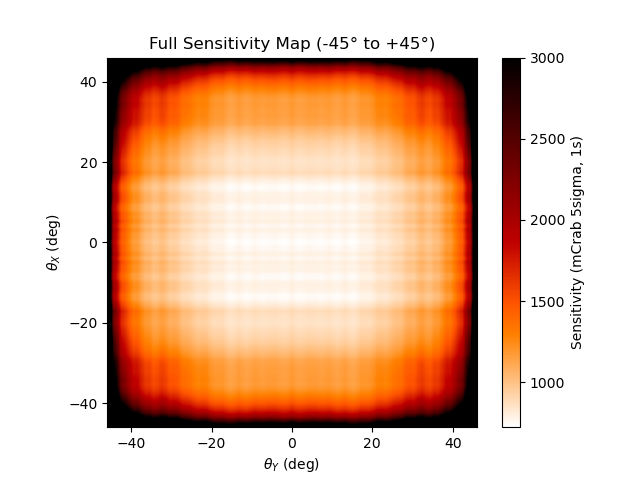

In [74]:
plt.figure()
plt.imshow(sens_map_mcrab_1s,cmap=cm.gist_heat_r, origin='lower', vmax=3000, interpolation='bilinear', extent=[-46,46,-46,46])
plt.colorbar(label='Sensitivity (mCrab 5sigma, 1s)')
plt.xlabel(r'$\theta_Y$ (deg)')
plt.ylabel(r'$\theta_X$ (deg)')
plt.title('Full Sensitivity Map (-45° to +45°)')
plt.show()

In [75]:
from astropy.io import fits

# 1. Define the filename
outfile = "sensitivity_map_mask_050_1040x17_20260129.fits"

# 2. Create the Primary HDU (Header Data Unit) containing the image data
hdu = fits.PrimaryHDU(sens_map_mcrab_1s)
header = hdu.header

# 3. Calculate the center pixel (reference pixel)
# Note: FITS uses 1-based indexing, Python uses 0-based.
# sens_map_full shape is (N_rows, N_cols) -> (ThetaX, ThetaY)
center_y = (sens_map_full.shape[0] - 1) / 2 + 1  # Axis 2 (Rows) -> ThetaX
center_x = (sens_map_full.shape[1] - 1) / 2 + 1  # Axis 1 (Cols) -> ThetaY

# 4. Add Coordinate System Metadata (WCS)
# AXIS 1: Horizontal (Columns) -> Theta Y
header['CTYPE1'] = 'ThetaY'        # Axis Type
header['CUNIT1'] = 'deg'           # Unit
header['CRPIX1'] = center_x        # Reference Pixel (Center)
header['CRVAL1'] = 0.0             # Value at Reference Pixel (0 degrees)
header['CDELT1'] = step            # Step size (1.0 degrees)

# AXIS 2: Vertical (Rows) -> Theta X
header['CTYPE2'] = 'ThetaX'        # Axis Type
header['CUNIT2'] = 'deg'           # Unit
header['CRPIX2'] = center_y        # Reference Pixel (Center)
header['CRVAL2'] = 0.0             # Value at Reference Pixel (0 degrees)
header['CDELT2'] = step            # Step size (1.0 degrees)

# Optional: Add other useful info
header['TELESCOP'] = 'Coded Mask Sim'
header['COMMENT'] = 'Sensitivity mCrab (5sigma, 1s)'

# 5. Write to file (overwrite if exists)
hdu.writeto(outfile, overwrite=True)

print(f"File saved to {outfile}")

File saved to sensitivity_map_mask_050_1040x17_20260129.fits
